In [1]:
from support.df_init import init

train = init()
test = init('pp_test.csv')

In [2]:
train = train.loc[~train['outlier_w_type']]
test = test.loc[~test['outlier_w_type']]

In [3]:
# from support.transformations import apply_transformations

# train, test = apply_transformations(train, test)

In [4]:
# from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler()
# train['userReviewsTotal'] = scaler.fit_transform(train[['userReviewsTotal']])
# test['userReviewsTotal'] = scaler.transform(test[['userReviewsTotal']])

# scaler_target = MinMaxScaler()
# train['criticReviewsTotal'] = scaler_target.fit_transform(train[['criticReviewsTotal']])
# test['criticReviewsTotal'] = scaler_target.transform(test[['criticReviewsTotal']])


In [5]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

def evaluate_model_with_inverse_transform(model, X_test, y_test_scaled, scaler_y):
    """
    Predicts using a trained model and evaluates performance after inverse transforming the predictions and targets.

    Parameters:
    - model: trained regression model
    - X_test: 2D array of input features
    - y_test_scaled: scaled target values (must be 2D)
    - scaler_y: fitted StandardScaler used to scale the target

    Prints MAE, MSE, and R^2 in the original (unscaled) space.
    """
    # Ensure y_test is 2D
    if y_test_scaled.ndim == 1:
        y_test_scaled = y_test_scaled.reshape(-1, 1)

    # Predict in scaled space
    y_pred_scaled = model.predict(X_test)

    # Also ensure predictions are 2D
    if y_pred_scaled.ndim == 1:
        y_pred_scaled = y_pred_scaled.reshape(-1, 1)

    # Inverse transform predictions and actual targets
    y_pred = scaler_y.inverse_transform(y_pred_scaled)
    y_pred = np.expm1(y_pred)
    y_test = scaler_y.inverse_transform(y_test_scaled)
    y_test = np.expm1(y_test)
    

    # Compute metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    normalized_mae = mae / np.median(y_test)
    normalized_mse = mse / np.median(y_test)


    print(f"MAE (original scale): {mae:.4f}")
    print(f"Normalized MAE: {normalized_mae:.4f}")
    print(f"MSE (original scale): {mse:.4f}")
    print(f"Normalized MSE: {normalized_mse:.4f}")
    print(f"R² (original scale): {r2:.4f}")


Train Mean Absolute Error: 3.0544167733228478
Train Mean Squared Error: 111.1981976329653
Train R-squared: 0.35726362700134096
Mean Absolute Error: 3.4187683254780588
Mean Squared Error: 189.54331325729277
R-squared: 0.4655022280225699
Intercept: 1.7596260327719293
Coefficients: [0.12601613]


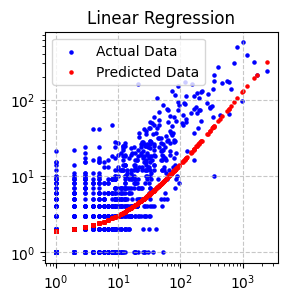

In [6]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import matplotlib.pyplot as plt

def train_linear_regressor(train: pd.DataFrame, test: pd.DataFrame, log: bool=False,):
    # Define the train set
    X_train = train['userReviewsTotal' if not log else 'userReviewsTotal_log'].values.reshape(-1, 1)
    y_train = train['criticReviewsTotal' if not log else 'criticReviewsTotal_log'].values

    # Define the test set
    X_test = test['userReviewsTotal' if not log else 'userReviewsTotal_log'].values.reshape(-1, 1)
    y_test = test['criticReviewsTotal'].values

    # Initialize and train the linear regression model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Inverse the log transformation
    if log:
        X_train = np.expm1(X_train)
        y_train = np.expm1(y_train)
        X_test = np.expm1(X_test)
        y_pred = np.expm1(y_pred)

    # print train mse, mae and r2
    y_train_pred = model.predict(X_train)
    mse_train = mean_squared_error(y_train, y_train_pred)
    mae_train = np.mean(np.abs(y_train - y_train_pred))
    print(f"Train Mean Absolute Error: {mae_train}")
    
    r2_train = r2_score(y_train, y_train_pred)
    print(f"Train Mean Squared Error: {mse_train}")
    print(f"Train R-squared: {r2_train}")

    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    mae = np.mean(np.abs(y_test - y_pred))
    print(f"Mean Absolute Error: {mae}")
    r2 = r2_score(y_test, y_pred)

    print(f"Mean Squared Error: {mse}")
    print(f"R-squared: {r2}")
    print(f"Intercept: {model.intercept_}")
    print(f"Coefficients: {model.coef_}")

    # Plot test data and predictions
    plt.figure(figsize=(3, 3))
    plt.scatter(X_test, y_test, color='blue', label='Actual Data', s=5)
    plt.scatter(X_test, y_pred, color='red', label='Predicted Data', s=5)
    plt.title('Linear Regression')
    # plt.xlabel('userReviewsTotal')
    # plt.ylabel('criticReviewsTotal')
    plt.legend()
    plt.grid(linestyle='--', alpha=0.7)
    plt.xscale('log')
    plt.yscale('log')
    plt.show()
    return model
    
model = train_linear_regressor(train, test, log=False)

In [7]:
# evaluate_model_with_inverse_transform(
#     model,
#     test[['userReviewsTotal']].values,  # Already 2D
#     test[['criticReviewsTotal']].values,  # <-- wrap y_test in double brackets to make it 2D
#     scaler_target
# )


# Ridge

Train Mean Absolute Error: 3.054550990699857
Train Mean Squared Error: 111.1981994565623
Train R-squared: 0.3572636164607733
Mean Absolute Error: 3.418928619624778
Mean Squared Error: 189.56112318023165
R-squared: 0.46545200539025255
Intercept: 1.7597642587891982
Coefficients: [0.12599449]
Best Alpha: 10000.0


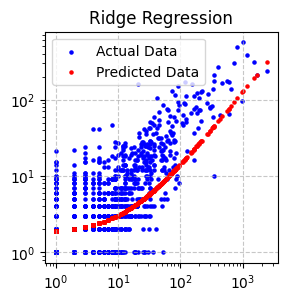

In [8]:

from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt

def train_ridge_lasso_regressor(train, test, log=False, model_type='ridge', alpha=1.0):
    # Define the train set
    X_train = train[['userReviewsTotal_log' if log else 'userReviewsTotal']].values
    y_train = train['criticReviewsTotal_log' if log else 'criticReviewsTotal'].values

    # Define the test set
    X_test = test[['userReviewsTotal_log' if log else 'userReviewsTotal']].values
    y_test = test['criticReviewsTotal'].values

    # Initialize the model
    if model_type.lower() == 'ridge':
        model = Ridge()
    elif model_type.lower() == 'lasso':
        model = Lasso()
    else:
        raise ValueError("Invalid model_type. Choose 'ridge' or 'lasso'.")

    model = GridSearchCV(
        estimator=model,
        param_grid={
            'alpha': np.logspace(-4, 4, 100),
        },
        cv=5,
        scoring='neg_mean_squared_error',
    )
    model.fit(X_train, y_train)
    model = model.best_estimator_
    # Train the model

    # Make predictions
    y_pred = model.predict(X_test)

    # Inverse the log transformation if necessary
    if log:
        X_train = np.expm1(X_train)
        y_train = np.expm1(y_train)
        X_test = np.expm1(X_test)
        y_pred = np.expm1(y_pred)

    # Print train mse, mae and r^2
    y_train_pred = model.predict(X_train)
    mse_train = mean_squared_error(y_train, y_train_pred)
    mae_train = np.mean(np.abs(y_train - y_train_pred))
    r2_train = r2_score(y_train, y_train_pred)
    print(f"Train Mean Absolute Error: {mae_train}")
    print(f"Train Mean Squared Error: {mse_train}")
    print(f"Train R-squared: {r2_train}")

    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    mae = np.mean(np.abs(y_test - y_pred))
    r2 = r2_score(y_test, y_pred)
    print(f"Mean Absolute Error: {mae}")
    print(f"Mean Squared Error: {mse}")
    print(f"R-squared: {r2}")
    print(f"Intercept: {model.intercept_}")
    print(f"Coefficients: {model.coef_}")
    
    print(f"Best Alpha: {model.alpha}")

    # Plot test data and predictions
    plt.figure(figsize=(3, 3))
    plt.scatter(X_test, y_test, color='blue', label='Actual Data', s=5)
    plt.scatter(X_test, y_pred, color='red', label='Predicted Data', s=5)
    plt.title(f'{model_type.capitalize()} Regression' + (' (Log)' if log else ''))
    # plt.xlabel('userReviewsTotal')
    # plt.ylabel('criticReviewsTotal')
    plt.yticks(None)
    plt.legend()
    plt.grid(linestyle='--', alpha=0.7)
    plt.xscale('log')
    plt.yscale('log')
    plt.show()
    return model


model = train_ridge_lasso_regressor(train, test, log=False, model_type='ridge')

In [9]:
# evaluate_model_with_inverse_transform(
#     model,
#     test[['userReviewsTotal']].values,  # Already 2D
#     test[['criticReviewsTotal']].values,  # <-- wrap y_test in double brackets to make it 2D
#     scaler_target
# )


# Lasso

Train Mean Absolute Error: 3.479309066022622
Train Mean Squared Error: 126.24607999816841
Train R-squared: 0.27028540668301215
Mean Absolute Error: 3.947936152300477
Mean Squared Error: 255.73218384062392
R-squared: 0.2788546314995002
Intercept: 2.156692354707362
Coefficients: [0.0638381]
Best Alpha: 242.01282647943833


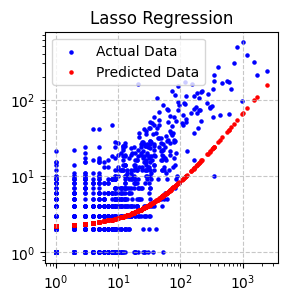

In [10]:
model = train_ridge_lasso_regressor(train, test, log=False, model_type='Lasso', )

In [11]:
# evaluate_model_with_inverse_transform(
#     model,
#     test[['userReviewsTotal']].values,  # Already 2D
#     test[['criticReviewsTotal']].values,  # <-- wrap y_test in double brackets to make it 2D
#     scaler_target
# )


# DT

Train Mean Absolute Error: 1.6112076026202498
Train Mean Squared Error: 22.609256883619086
Train R-squared: 0.8693163012089661
Mean Absolute Error: 2.5656458511987967
Mean Squared Error: 189.3755004577299
R-squared: 0.46597544739356334


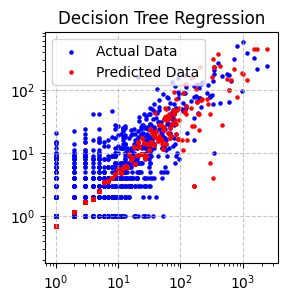

In [12]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV, RepeatedKFold
import matplotlib.pyplot as plt

def train_dt_regressor(train, test, log=False, param_distributions=None, n_iter=30, cv=3, random_state=42):
    # Define the train set
    X_train = train[['userReviewsTotal_log' if log else 'userReviewsTotal']].values
    y_train = train['criticReviewsTotal_log' if log else 'criticReviewsTotal'].values

    # Define the test set
    X_test = test[['userReviewsTotal_log' if log else 'userReviewsTotal']].values
    y_test = test['criticReviewsTotal'].values

    # Initialize the Decision Tree Regressor
    dt_model = DecisionTreeRegressor(random_state=random_state,
                                     criterion='squared_error',)
    
    cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=random_state)

    # Perform RandomizedSearchCV if param_distributions is provided
    if param_distributions:
        random_search = RandomizedSearchCV(
            estimator=dt_model,
            param_distributions=param_distributions,
            n_iter=n_iter,
            cv=cv,
            scoring='neg_mean_squared_error',
            random_state=random_state,
            n_jobs=-1
        )
        random_search.fit(X_train, y_train)
        dt_model = random_search.best_estimator_
        print(f"Best Parameters: {random_search.best_params_}")

    # Train the model
    dt_model.fit(X_train, y_train)

    y_train_pred = dt_model.predict(X_train)

    # Make predictions
    y_pred = dt_model.predict(X_test)

    # Inverse the log transformation if necessary
    if log:
        X_train = np.expm1(X_train)
        y_train = np.expm1(y_train)
        X_test = np.expm1(X_test)
        y_pred = np.expm1(y_pred)
        y_train_pred = np.expm1(y_train_pred)

    # Print train mse, mae and r^2
    mse_train = mean_squared_error(y_train, y_train_pred)
    mae_train = np.mean(np.abs(y_train - y_train_pred))
    r2_train = r2_score(y_train, y_train_pred)
    print(f"Train Mean Absolute Error: {mae_train}")
    print(f"Train Mean Squared Error: {mse_train}")
    print(f"Train R-squared: {r2_train}")

    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    mae = np.mean(np.abs(y_test - y_pred))
    print(f"Mean Absolute Error: {mae}")
    r2 = r2_score(y_test, y_pred)

    print(f"Mean Squared Error: {mse}")
    print(f"R-squared: {r2}")

    # Plot test data and predictions
    plt.figure(figsize=(3, 3))
    plt.scatter(X_test, y_test, color='blue', label='Actual Data', s=5)
    plt.scatter(X_test, y_pred, color='red', label='Predicted Data', s=5)
    plt.title('Decision Tree Regression' + (' (Log)' if log else ''))
    # plt.xlabel('userReviewsTotal')
    # plt.ylabel('criticReviewsTotal')
    plt.legend()
    plt.grid(linestyle='--', alpha=0.7)
    plt.xscale('log')
    plt.yscale('log')
    plt.show()
    return dt_model
    
model = train_dt_regressor(train, test, log=False)

Best Parameters: {'ccp_alpha': 0.07132447872229951, 'criterion': 'squared_error', 'max_depth': 4, 'max_leaf_nodes': 14, 'min_impurity_decrease': 0.04937955963643908, 'min_samples_leaf': 9, 'min_samples_split': 16}
Train Mean Absolute Error: 2.015365681596684
Train Mean Squared Error: 55.425216709302354
Train R-squared: 0.6796368689537032
Mean Absolute Error: 2.2296073894866137
Mean Squared Error: 109.67763052458275
R-squared: 0.690717397814097


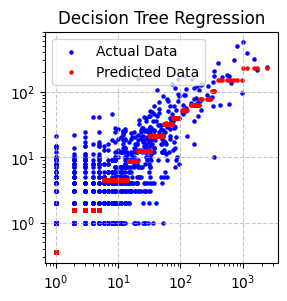

In [13]:
from scipy.stats import uniform

param_distributions = {
    'max_depth': [None] + list(range(1, 51)),  # None or depths from 1 to 20
    'min_samples_split': list(range(2, 21)),      # Minimum samples required to split an internal node
    'min_samples_leaf': list(range(1, 21)),       # Minimum samples required to be at a leaf node
    # 'max_features': ['auto', 'sqrt', 'log2'],      # Number of features to consider when looking for the best split
    'max_leaf_nodes': [None] + list(range(2, 21)),  # Number of leaf nodes
    # 'min_weight_fraction_leaf': [0.0, 0.1, 0.2],  # Minimum weighted fraction of the sum total of weights
    'min_impurity_decrease': uniform(0.0, 0.1),  # Minimum impurity decrease required to split a node
    'criterion': ['squared_error', 'friedman_mse'],  # Splitting criteria
    'ccp_alpha': uniform(0.0, 0.1)  # Complexity parameter for Minimal Cost-Complexity Pruning
}

model = train_dt_regressor(train, test, log=False, param_distributions=param_distributions, n_iter=200, cv=5)

In [14]:
# evaluate_model_with_inverse_transform(
#     model,
#     test[['userReviewsTotal']].values,  # Already 2D
#     test[['criticReviewsTotal']].values,  # <-- wrap y_test in double brackets to make it 2D
#     scaler_target
# )


# KNN

Train Mean Absolute Error: 1.9365624651732978
Train Mean Squared Error: 59.226165881904976
Train R-squared: 0.6576670138917124
Mean Absolute Error: 2.2210836514633985
Mean Squared Error: 126.53915650882949
R-squared: 0.6431691730002487


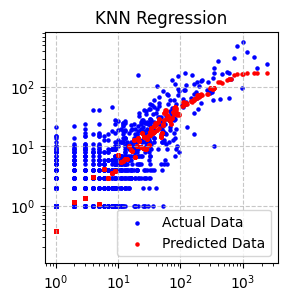

In [15]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score

import matplotlib.pyplot as plt

def train_knn_regressor(train, test, log=False, n_neighbors=5) -> KNeighborsRegressor:
    # Define the train set
    X_train = train[['userReviewsTotal_log' if log else 'userReviewsTotal']].values
    y_train = train['criticReviewsTotal_log' if log else 'criticReviewsTotal'].values

    # Define the test set
    X_test = test[['userReviewsTotal_log' if log else 'userReviewsTotal']].values
    y_test = test['criticReviewsTotal'].values

    # Initialize the KNN Regressor

    model = GridSearchCV(
        estimator=KNeighborsRegressor(),
        param_grid={
            'n_neighbors': range(1, 51),
        },
        cv=5,
        scoring='r2',
        n_jobs=-1
    )
    model.fit(X_train, y_train)
    knn_model = model.best_estimator_
    # Train the model
    knn_model.fit(X_train, y_train)

    # Make predictions
    y_pred = knn_model.predict(X_test)

    # Inverse the log transformation if necessary
    if log:
        X_train = np.expm1(X_train)
        y_train = np.expm1(y_train)
        X_test = np.expm1(X_test)
        y_pred = np.expm1(y_pred)

    # print train mse, mae and r^2
    y_train_pred = knn_model.predict(X_train)
    mse_train = mean_squared_error(y_train, y_train_pred)
    mae_train = np.mean(np.abs(y_train - y_train_pred))
    r2_train = r2_score(y_train, y_train_pred)
    print(f"Train Mean Absolute Error: {mae_train}")
    print(f"Train Mean Squared Error: {mse_train}")
    print(f"Train R-squared: {r2_train}")

    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred) 
    mae = np.mean(np.abs(y_test - y_pred))
    print(f"Mean Absolute Error: {mae}")
    print(f"Mean Squared Error: {mse}")
    print(f"R-squared: {r2}")

    # Plot test data and predictions
    plt.figure(figsize=(3, 3))
    plt.scatter(X_test, y_test, color='blue', label='Actual Data', s=5)
    plt.scatter(X_test, y_pred, color='red', label='Predicted Data', s=5)
    plt.title('KNN Regression' + (' (Log)' if log else ''))
    # plt.xlabel('userReviewsTotal')
    # plt.ylabel('criticReviewsTotal')
    plt.legend()
    plt.grid(linestyle='--', alpha=0.7)
    plt.xscale('log')
    plt.yscale('log')
    plt.show()
    
    return knn_model

# Example usage
model = train_knn_regressor(train, test, log=False, n_neighbors=20)

In [16]:
# evaluate_model_with_inverse_transform(
#     model,
#     test[['userReviewsTotal']].values,  # Already 2D
#     test[['criticReviewsTotal']].values,  # <-- wrap y_test in double brackets to make it 2D
#     scaler_target
# )


In [17]:
from sklearn.model_selection import train_test_split

# Define a range of k values
k_values = range(1, 51)
mae_values = []
mse_values = []

# Split train into train and validation sets
train_split, val_split = train_test_split(train, test_size=0.3, random_state=42)

mae_values_validation = []
mse_values_validation = []

def train_knn_regressor_mae_mse(train, test, log=False, n_neighbors=5):
    # Define the train set
    X_train = train[['userReviewsTotal_log' if log else 'userReviewsTotal']].values
    y_train = train['criticReviewsTotal_log' if log else 'criticReviewsTotal'].values

    # Define the test set
    X_test = test[['userReviewsTotal_log' if log else 'userReviewsTotal']].values
    y_test = test['criticReviewsTotal'].values

    # Initialize the KNN Regressor
    knn_model = KNeighborsRegressor(n_neighbors=n_neighbors)

    # Train the model
    knn_model.fit(X_train, y_train)

    # Make predictions
    y_pred = knn_model.predict(X_test)

    # Inverse the log transformation if necessary
    if log:
        X_train = np.expm1(X_train)
        y_train = np.expm1(y_train)
        X_test = np.expm1(X_test)
        y_pred = np.expm1(y_pred)

    train_mse = mean_squared_error(y_train, knn_model.predict(X_train))  / (np.max(y_train) - np.min(y_train))
    train_mae = np.mean(np.abs(y_train - knn_model.predict(X_train)))  / (np.max(y_train) - np.min(y_train))
    # Evaluate the model
    test_mse = mean_squared_error(y_test, y_pred) / (np.max(y_test) - np.min(y_test))
    r2 = r2_score(y_test, y_pred)
    test_mae = np.mean(np.abs(y_test - y_pred)) / (np.max(y_test) - np.min(y_test))
    
    return train_mse, train_mae, test_mse, test_mae

# Train KNN regressors for each k and calculate MAE
for k in k_values:
    train_mse, train_mae, test_mse, test_mae = train_knn_regressor_mae_mse(
        train_split, val_split, log=False, n_neighbors=k)
    
    mae_values.append(train_mae)
    mse_values.append(train_mse)
    mae_values_validation.append(test_mae)
    mse_values_validation.append(test_mse)

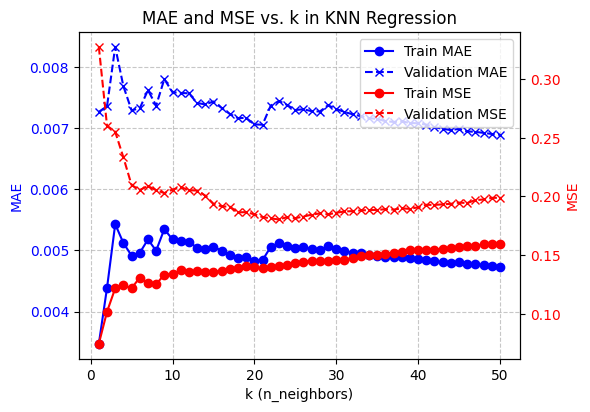

In [18]:
fig, ax1 = plt.subplots(figsize=(6, 4))

# Train MAE (left y-axis)
ax1.plot(k_values, mae_values, 'b-o', label='Train MAE')
ax1.plot(k_values, mae_values_validation, 'b--x', label='Validation MAE')
ax1.set_xlabel('k (n_neighbors)')
ax1.set_ylabel('MAE', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Right y-axis for MSE
ax2 = ax1.twinx()
ax2.plot(k_values, mse_values, 'r-o', label='Train MSE')
ax2.plot(k_values, mse_values_validation, 'r--x', label='Validation MSE')
ax2.set_ylabel('MSE', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')


fig.tight_layout()

plt.title('MAE and MSE vs. k in KNN Regression')
ax1.grid(True, axis='both', linestyle='--', alpha=0.7)
plt.show()

aaaaa

In [19]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

def train_and_evaluate_model(ModelClass, X_train, y_train, X_test, y_test, params_distribution=None, **model_params):
    """
    Trains a model and evaluates it on train and test data.

    Parameters:
    - ModelClass: The class of the model to be trained (e.g., sklearn.linear_model.LinearRegression).
    - train: Training DataFrame.
    - test: Testing DataFrame.
    - feats: List of feature column names.
    - targets: List of target column names.
    - model_params: Additional parameters to initialize the model.

    Returns:
    - model: Trained model.
    - metrics: Dictionary containing MAE, MSE, and R^2 for train and test.
    """
    if params_distribution:
        # If a distribution is provided, run random search
        model = RandomizedSearchCV(
            ModelClass(**model_params),
            param_distributions=params_distribution,
            n_iter=50,
            cv=5,
            verbose=1,
            n_jobs=-1,
            scoring='neg_mean_squared_error',
        )
        model.fit(X_train, y_train)
        # Get the best model
        model = model.best_estimator_
    else:
        model = ModelClass(**model_params)
        model.fit(X_train, y_train)

    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Calculate metrics
    metrics = {
        'train': {
            'mae': mean_absolute_error(y_train, y_train_pred),
            'mse': mean_squared_error(y_train, y_train_pred),
            'r2': r2_score(y_train, y_train_pred)
        },
        'test': {
            'mae': mean_absolute_error(y_test, y_test_pred),
            'mse': mean_squared_error(y_test, y_test_pred),
            'r2': r2_score(y_test, y_test_pred)
        }
    }

    return model, metrics

In [20]:
def print_model_summary(metrics):
    print("Train Metrics:")
    print('MAE: %.3f' % metrics['train']['mae'])
    print('MSE: %.3f' % metrics['train']['mse'])
    print('R-squared: %.3f' % metrics['train']['r2'])

    print("\nTest Metrics:")
    print('MAE: %.3f' % metrics['test']['mae'])
    print('MSE: %.3f' % metrics['test']['mse'])
    print('R-squared: %.3f' % metrics['test']['r2'])

In [21]:
model, _ = train_and_evaluate_model(
    ModelClass=LinearRegression,
    X_train=train[['userReviewsTotal']].values,
    y_train=train['criticReviewsTotal'].values,
    X_test=test[['userReviewsTotal']].values,
    y_test=test['criticReviewsTotal'].values
)

In [22]:
train_and_evaluate_model(
    ModelClass=Ridge,
    X_train=train[['userReviewsTotal']].values,
    y_train=train['criticReviewsTotal'].values,
    X_test=test[['userReviewsTotal']].values,
    y_test=test['criticReviewsTotal'].values,
    params_distribution={
        'alpha': np.logspace(-4, 4, 100),
    }
)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


(Ridge(alpha=3274.5491628777318),
 {'train': {'mae': 3.0544607285405267,
   'mse': 111.19819782854881,
   'r2': 0.35726362587084926},
  'test': {'mae': 3.418820820648719,
   'mse': 189.54914547665612,
   'r2': 0.46548578160617127}})

In [23]:
train_and_evaluate_model(
    ModelClass=Lasso,
    X_train=train[['userReviewsTotal']].values,
    y_train=train['criticReviewsTotal'].values,
    X_test=test[['userReviewsTotal']].values,
    y_test=test['criticReviewsTotal'].values,
    params_distribution={
        'alpha': np.logspace(-4, 4, 100),
    }
)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


(Lasso(alpha=242.01282647943833),
 {'train': {'mae': 3.479309066022622,
   'mse': 126.24607999816841,
   'r2': 0.27028540668301215},
  'test': {'mae': 3.947936152300477,
   'mse': 255.73218384062392,
   'r2': 0.2788546314995002}})

In [24]:
train_and_evaluate_model(
    ModelClass=DecisionTreeRegressor,
    X_train=train[['userReviewsTotal']].values,
    y_train=train['criticReviewsTotal'].values,
    X_test=test[['userReviewsTotal']].values,
    y_test=test['criticReviewsTotal'].values,
    params_distribution={
        'max_depth': [None] + list(range(1, 51)),
        'min_samples_split': list(range(2, 21)),
        'min_samples_leaf': list(range(1, 21)),
        'max_leaf_nodes': [None] + list(range(2, 21)),
        'min_impurity_decrease': uniform(0.0, 0.1),
        'criterion': ['squared_error', 'friedman_mse'],
        'ccp_alpha': uniform(0.0, 0.1)
    }
)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


(DecisionTreeRegressor(ccp_alpha=0.09896414622472982, criterion='friedman_mse',
                       max_depth=49, max_leaf_nodes=10,
                       min_impurity_decrease=0.09786128775520106,
                       min_samples_leaf=15, min_samples_split=17),
 {'train': {'mae': 2.0855485041713138,
   'mse': 58.20601682315451,
   'r2': 0.6635635744466191},
  'test': {'mae': 2.337918611123726,
   'mse': 121.21920868506902,
   'r2': 0.658171022498238}})

In [25]:
train_and_evaluate_model(
    ModelClass=KNeighborsRegressor,
    X_train=train[['userReviewsTotal']].values,
    y_train=train['criticReviewsTotal'].values,
    X_test=test[['userReviewsTotal']].values,
    y_test=test['criticReviewsTotal'].values,
    params_distribution={
        'n_neighbors': range(1, 51),
    }
)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


(KNeighborsRegressor(n_neighbors=24),
 {'train': {'mae': 1.9365624651732978,
   'mse': 59.226165881904976,
   'r2': 0.6576670138917124},
  'test': {'mae': 2.2210836514633985,
   'mse': 126.53915650882949,
   'r2': 0.6431691730002487}})